<h1> CSCI 567 - Machine Learning - Spring 2021 </h1>
<h2> Project: Chekcpoint 1 - Data Preprocessing (03/10/21) </h2>
<h3> Team <u>StochasticResults</u>: </h3>
 - Abel Salinas [8793999216] [abelsali@usc.edu] <br>
 - Angel Nieto [2211798052] [nietogar@usc.edu] <br>
 - Misael Morales [5832732058] [misaelmo@usc.edu]

***

The "Housing Price" dataset consists of 79 predictors for the house prices in Ames, Iowa. The training and testing set are already pre-split for us from the Kaggle version (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview), and we will focus on different regression techniques to predict the housing SalePrice based on the given features.

This notebook focuses on the data pre-processing, wrangling, visualization, and statistical analysis. It is a crucial step in any machine-learning/data-analytics application to ensure proper data formatting in order to optimize the techniques implemented. 

# Table of Contents:
1. Load required packages <br>
2. Data wrangling <br>
3. Data visualization <br>
4. Exploratory data analysis

***

# 1. Load required libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Basic data management packages
import os
import numpy as np
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.plotting as pd_plot
%matplotlib inline

In [4]:
# Exploratory Data Analysis packages
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA  
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import (BaggingRegressor, AdaBoostRegressor,GradientBoostingRegressor, 
                              RandomForestRegressor,  GradientBoostingRegressor)
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import r2_score, mean_absolute_error

from scipy.stats import norm, skew #for some statistics

#from lightgbm import LGBMRegressor
#import xgboost
import lightgbm

In [5]:
# Regression and Modeling packages
import tensorflow as tf
import keras
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

# Verify GPU compatibility
print("Tensorflow Version:", tf.__version__)
print("Tensorflow built with CUDA?", tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('CPU'))
print(tf.config.list_physical_devices('GPU'))
print("Num GPU Available:", len(tf.config.list_physical_devices('GPU')))

Tensorflow Version: 2.3.0
Tensorflow built with CUDA? False
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
Num GPU Available: 0


***

In [6]:
# Read CSV files for Train/Test datasets
train_csv = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
test_csv  = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
if not os.path.isfile(train_csv):
    train_csv = 'train.csv'
    test_csv = 'test.csv'
    
train_df = pd.read_csv(train_csv)
test_df  = pd.read_csv(test_csv)

In [7]:
print('Train Shape: {} | types: {} \nTest Shape:  {} | types: {}'.format(train_df.shape, pd.unique(train_df.dtypes), 
                                                                       test_df.shape, pd.unique(test_df.dtypes)))
print('Set difference train-vs-test: {}'.format(set(train_df.columns).difference(set(test_df.columns))))

Train Shape: (1460, 81) | types: [dtype('int64') dtype('O') dtype('float64')] 
Test Shape:  (1459, 80) | types: [dtype('int64') dtype('O') dtype('float64')]
Set difference train-vs-test: {'SalePrice'}


In [8]:
original_train_df = train_df.copy()
corr = train_df.corr()

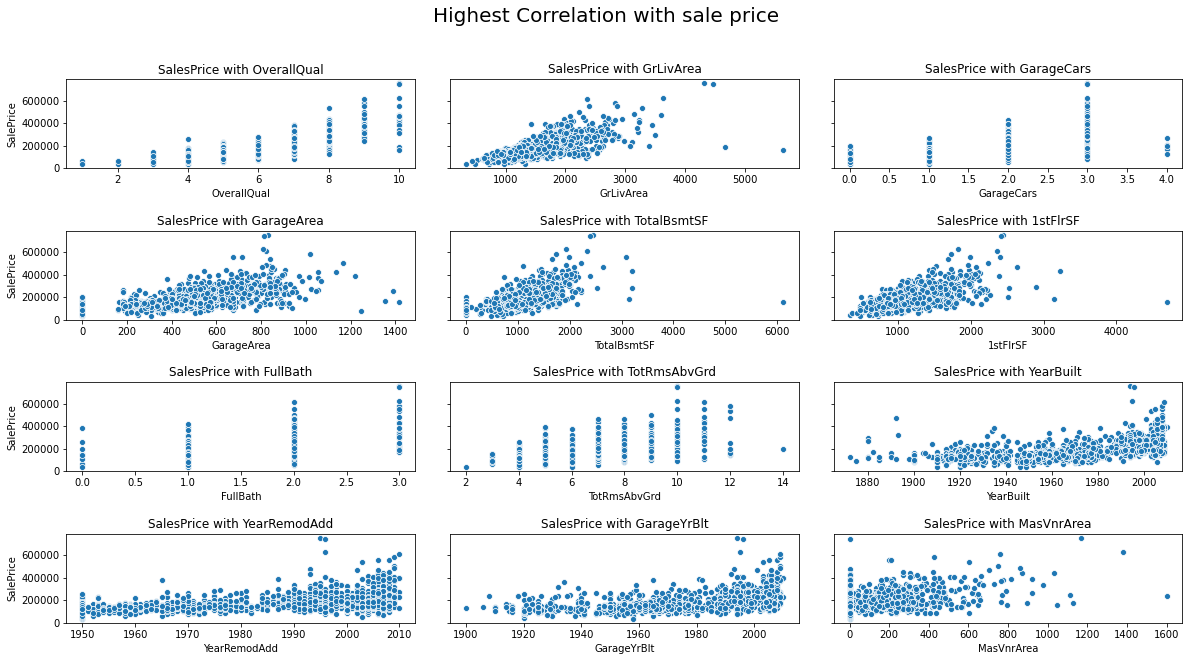

In [9]:
#Visualize columns have corr with SalePrice

high_corr = corr['SalePrice'].sort_values(ascending=False)[1:][:13].index.tolist()

fig, axes = plt.subplots(4,3, figsize=(20, 10), sharey=True);
plt.subplots_adjust(hspace = 0.7, wspace=0.1)
fig.suptitle('Highest Correlation with sale price', fontsize=20);

for i,col in zip(range(12),high_corr):
    sns.scatterplot(y=train_df['SalePrice'], x=train_df[col], ax=axes[i//3][i%3])
    axes[i//3][i%3].set_title('SalesPrice with '+col)

In [10]:
#selectting the index of outliers from the scatter plots above

drop_index = train_df[((train_df['GarageArea']>1200) & (train_df['SalePrice']<300000))|
                  ((train_df['GrLivArea']>5000) & (train_df['SalePrice']<300000))|
                  ((train_df['1stFlrSF']>4000) & (train_df['SalePrice']<300000))|
                  ((train_df['TotalBsmtSF']>5000) & (train_df['SalePrice']<300000))|
                  ((train_df['MasVnrArea']>1200) & (train_df['SalePrice']<700000))|
                  ((train_df['SalePrice']>600000))].index

In [11]:
x_train = train_df.iloc[:,1:-1]  #79 train features
y_train = train_df.iloc[:,-1]    #SalePrice training target

y_train = np.log1p(y_train) 

x_test  = test_df.iloc[:,1:]     #79 test features
print('x_train {} | y_train {} \nx_test  {}'.format(x_train.shape, y_train.shape, x_test.shape))

x_train (1460, 79) | y_train (1460,) 
x_test  (1459, 79)


In [12]:
#preview the training data set
x_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [13]:
#preview the testing data set
x_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [14]:
x_train = x_train.drop(drop_index)
y_train = y_train.drop(drop_index)

In [15]:
numerical_feats = x_train.dtypes[x_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = x_train.dtypes[x_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  36
Number of Categorical features:  43


In [16]:
total = x_train.isnull().sum().sort_values(ascending=False)
percent = (x_train.isnull().sum()/x_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
PoolQC,1446,0.996554
MiscFeature,1398,0.963473
Alley,1361,0.937974
Fence,1171,0.807030
FireplaceQu,689,0.474845
LotFrontage,258,0.177808
GarageCond,81,0.055824
GarageType,81,0.055824
GarageYrBlt,81,0.055824
GarageFinish,81,0.055824


In [17]:
# Non-numeric variables that require attention
non_num_vars = x_train.dtypes[x_train.dtypes=='object'].index
print(non_num_vars)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [18]:
# Replace object/string values with categorial values from the "data_description" file from Kaggle
mappings = dict(
MSZoning_mapping      = {'nan':0, 'A':1, 'C (all)':2, 'FV':3, 'I':4, 'RH':5, 'RL':6, 'RP':7, 'RM':8},
Street_mapping        = {'nan':0, 'Grvl':1, 'Pave':2},
Alley_mapping         = {'nan':0, 'Grvl':1, 'Pave':2, 'NaN':0},
LotShape_mapping      = {'nan':0, 'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4 },
LandContour_mapping   = {'nan':0, 'Lvl':1, 'Bnk':2, 'HLS':3, 'Low':4},
Utilities_mapping     = {'nan':0, 'AllPub':1, 'NoSewr':2, 'NoSeWa':3, 'ELO':4},
LotConfig_mapping     = {'nan':0, 'Inside':1, 'Corner':2, 'CulDSac':3, 'FR2':4, 'FR3':5},
LandSlope_mapping     = {'nan':0, 'Gtl':1, 'Mod':2, 'Sev':3},
Neighborhood_mapping  = {'nan':0, 'Blmngtn':1, 'Blueste':2, 'BrDale':3, 'BrkSide':4, 'ClearCr':5, 'CollgCr':6, 'Crawfor':7,
                         'Edwards':8, 'Gilbert':9, 'IDOTRR':10, 'MeadowV':11, 'Mitchel':12, 'NAmes':13, 'NoRidge':14, 
                         'NPkVill':15, 'NridgHt':16, 'NWAmes':17, 'OldTown':18, 'SWISU':19, 'Sawyer':20, 'SawyerW':21, 
                         'Somerst':22, 'StoneBr':23, 'Timber':24, 'Veenker':25},
Condition1_mapping    = {'nan':0, 'Artery':1, 'Feedr':2, 'Norm':3, 'RRNn':4, 'RRAn':5, 'PosN':6, 'PosA':7, 'RRNe':8, 'RRAe':9},
Condition2_mapping    = {'nan':0, 'Artery':1, 'Feedr':2, 'Norm':3, 'RRNn':4, 'RRAn':5, 'PosN':6, 'PosA':7, 'RRNe':8, 'RRAe':9},
BldgType_mapping      = {'nan':0, '1Fam':1, '2fmCon':2, 'Duplex':3, 'Twnhs':4, 'TwnhsE':4, 'TwnhsI':5},
HouseStyle_mapping    = {'nan':0, '1Story':1, '1.5Fin':2, '1.5Unf':3, '2Story':4, '2.5Fin':5, '2.5Unf':6, 'SFoyer':7, 'SLvl':8},
RoofStyle_mapping     = {'nan':0, 'Flat':1, 'Gable':2, 'Gambrel':3, 'Hip':4, 'Mansard':5, 'Shed':6},
RoofMatl_mapping      = {'nan':0, 'ClyTile':1, 'CompShg':2, 'Membran':3, 'Metal':4, 
                         'Roll':5, 'Tar&Grv':6, 'WdShake':7, 'WdShngl':8},
Exterior1st_mapping   = {'nan':0, 'AsbShng':1, 'AsphShn':2, 'BrkComm':3, 'BrkFace':4, 'CBlock':5, 'CemntBd':6, 
                         'HdBoard':7, 'ImStucc':8, 'MetalSd':9, 'Other':10, 'Plywood':11, 'PreCast':12, 'Stone':13, 
                         'Stucco':14, 'VinylSd':15,'Wd Sdng':16, 'WdShing':17},
Exterior2nd_mapping   = {'nan':0, 'AsbShng':1, 'AsphShn':2, 'Brk Cmn':3, 'BrkFace':4, 'CBlock':5, 'CmentBd':6, 
                         'HdBoard':7, 'ImStucc':8, 'MetalSd':9, 'Other':10, 'Plywood':11, 'PreCast':12, 'Stone':13, 
                         'Stucco':14, 'VinylSd':15, 'Wd Shng':16, 'Wd Sdng':16, 'WdShing':17},
MasVnrType_mapping    = {'nan':0, 'BrkCmn':1, 'BrkFace':2, 'CBlock':3, 'None':4, 'Stone':5},
ExterQual_mapping     = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5},
ExterCond_mapping     = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5},
Foundation_mapping    = {'nan':0, 'BrkTil':1, 'CBlock':2, 'PConc':3, 'Slab':4, 'Stone':5, 'Wood':6},
BsmtQual_mapping      = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':0},
BsmtCond_mapping      = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':0},
BsmtExposure_mapping  = {'nan':0, 'Gd':1, 'Av':2, 'Mn':3, 'No':4, 'NA':5},
BsmtFinType1_mapping  = {'nan':0, 'GLQ':1, 'ALQ':2, 'BLQ':3, 'Rec':4, 'LwQ':5, 'Unf':6, 'NA':0},
BsmtFinType2_mapping  = {'nan':0, 'GLQ':1, 'ALQ':2, 'BLQ':3, 'Rec':4, 'LwQ':5, 'Unf':6, 'NA':0},
Heating_mapping       = {'nan':0, 'Floor':1, 'GasA':2, 'GasW':3, 'Grav':4, 'OthW':5, 'Wall':6},
HeatingQC_mapping     = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5},
CentralAir_mapping    = {'nan':0, 'N':1, 'Y':2},
Electrical_mapping    = {'nan':0, 'SBrkr':1, 'FuseA':2, 'FuseF':3, 'FuseP':4, 'Mix':5},
KitchenQual_mapping   = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5},
Functional_mapping    = {'nan':0, 'Typ':1, 'Min1':2, 'Min2':3, 'Mod':4, 'Maj1':5, 'Maj2':6, 'Sev':7, 'Sal':8},
FireplaceQu_mapping   = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':0},
GarageType_mapping    = {'nan':0, '2Types':1, 'Attchd':2, 'Basment':3, 'BuiltIn':4, 'CarPort':5, 'Detchd':6, 'NA':0},
GarageFinish_mapping  = {'nan':0, 'Fin':1, 'RFn':2, 'Unf':3, 'NA':0},
GarageQual_mapping    = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':0},
GarageCond_mapping    = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'Po':5, 'NA':0},
PavedDrive_mapping    = {'nan':0, 'Y':1, 'P':2, 'N':3},
PoolQC_mapping        = {'nan':0, 'Ex':1, 'Gd':2, 'TA':3, 'Fa':4, 'NA':0},
Fence_mapping         = {'nan':0, 'GdPrv':1, 'MnPrv':2, 'GdWo':3, 'MnWw':4, 'NA':0},
MiscFeature_mapping   = {'nan':0, 'Elev':1, 'Gar2':2, 'Othr':3, 'Shed':4, 'TenC':5, 'NA':0},
SaleType_mapping      = {'nan':0, 'WD':1, 'CWD':2, 'VWD':3, 'New':4, 'COD':5, 'Con':6, 'ConLw':7, 'ConLI':8,
                         'ConLD':9, 'Oth':10},
SaleCondition_mapping = {'nan':0, 'Normal':1, 'Abnorml':2, 'AdjLand':3, 'Alloca':4, 'Family':5, 'Partial':6})

In [19]:
x_train = x_train.replace({list(non_num_vars)[k] : list(mappings.values())[k] 
                           for k in np.arange(len(list(non_num_vars)))}).fillna(0)
x_test  = x_test.replace({list(non_num_vars)[k] : list(mappings.values())[k] 
                           for k in np.arange(len(list(non_num_vars)))}).fillna(0)

print('x_train {} | y_train {} \nx_test  {}'.format(x_train.shape, y_train.shape, x_test.shape))

x_train (1451, 79) | y_train (1451,) 
x_test  (1459, 79)


In [20]:
numerical_feats = x_train.dtypes[x_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = x_train.dtypes[x_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  79
Number of Categorical features:  0


In [21]:
all_data = pd.concat((x_train, x_test)).reset_index(drop=True)

In [22]:
# Check the skew of all numerical features
skewed_feats = all_data[numerical_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
PoolQC,25.893964
Utilities,22.022716
MiscVal,21.923073
PoolArea,18.685646
LotArea,13.153061
Condition2,12.458280
LowQualFinSF,12.069749
Heating,12.059796
3SsnPorch,11.358122
RoofMatl,8.809237


In [23]:
skewness = skewness[abs(skewness) > 0.5]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 79 skewed numerical features to Box Cox transform


In [24]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2910, 79)


In [25]:
original_x_train = x_train.copy()
original_x_test = x_test.copy()

x_train = all_data[:len(x_train)]
x_test = all_data[len(x_train):]

***

In [26]:
# from sklearn.linear_model import LinearRegression

# lr = LinearRegression()
# lr.fit(x_train, y_train)
# pred = lr.predict(x_test)
# pred_train = lr.predict(x_train)
# r2 = r2_score(y_train,pred_train)
# rmse = np.sqrt(mean_squared_error(y_train,pred_train))
# print( 'R^2:', r2_score(y_train, pred_train ))
# print( 'MAE:', mean_absolute_error(y_train, pred_train))

In [27]:
# from sklearn.ensemble import RandomForestRegressor

# rf = RandomForestRegressor() #default features
# rf_fit = rf.fit(x_train, y_train)
# pred = rf_fit.predict(x_test)
# pred_train = rf.predict(x_train)
# r2 = r2_score(y_train,pred_train)
# rmse = np.sqrt(mean_squared_error(y_train,pred_train))
# print( 'R^2:', r2_score(y_train, pred_train ))
# print( 'MAE:', mean_absolute_error(y_train, pred_train))

In [28]:
# import xgboost
# # reg = xgboost.XGBRegressor().fit(x_train, y_train)
# xgbmodel = xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=1,
#                              random_state =7, nthread = -1)
# reg = xgbmodel.fit(x_train, y_train)
# pred = reg.predict(x_test)
# pred_train = reg.predict(x_train)
# r2 = r2_score(y_train,pred_train)
# rmse = np.sqrt(mean_squared_error(y_train,pred_train))
# print( 'R^2:', r2_score(y_train, pred_train ))
# print( 'MAE:', mean_absolute_error(y_train, pred_train))

In [29]:
# gbrt = GradientBoostingRegressor(max_depth=2048, warm_start=True)
# min_val_error = float("inf") 
# error_going_up = 0
# size=len(x_train)
# x_val, y_val = x_train[size-400:], y_train[size-400:]
# x_train_new, y_train_new = x_train[:-400], y_train[:-400]

# for n_estimators in range(1, 12000):
#     gbrt.n_estimators = n_estimators 
#     gbrt.fit(x_train_new, y_train_new)
#     y_pred = gbrt.predict(x_val)
#     val_error = mean_squared_error(y_val, y_pred) 
#     if val_error < min_val_error:
#         min_val_error = val_error
#         error_going_up = 0
#     else:
#         error_going_up += 1
#         if error_going_up == 10:
#             break # early stopping
            
# pred = gbrt.predict(x_test)
# pred_train = gbrt.predict(x_train)
# r2 = r2_score(y_train,pred_train)
# rmse = np.sqrt(mean_squared_error(y_train,pred_train))
# print( 'R^2:', r2_score(y_train, pred_train ))
# print( 'MAE:', mean_absolute_error(y_train, pred_train))

In [30]:
#Define our base and meta models for stacking

base_models = (KernelRidge(),
               make_pipeline(RobustScaler(),Lasso(alpha=0.0005, random_state=1)),
               make_pipeline(RobustScaler(),ElasticNet(alpha=0.0005, l1_ratio=0.9)),             
               make_pipeline(StandardScaler(),GradientBoostingRegressor(learning_rate=0.005, 
                                                                        loss='huber',
                                                                        max_depth=4, 
                                                                        max_features='sqrt',
                                                                        min_samples_leaf=15,
                                                                        min_samples_split=10,
                                                                        n_estimators=3000,
                                                                        random_state=1,
                                                                       )))
    
meta_model = lightgbm.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


In [31]:
#Building the stacking model
n_folds = 10
kfold = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train)

stack = StackingCVRegressor(regressors=base_models,
                            meta_regressor=meta_model, 
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False,cv=kfold,
                            random_state=1)

In [32]:
reg = stack.fit(x_train, y_train)
pred = np.expm1(reg.predict(x_test))
pred_train = reg.predict(x_train)
r2 = r2_score(y_train,pred_train)
rmse = np.sqrt(mean_squared_error(y_train,pred_train))
print('RMSE:',  rmse)
print( 'R^2:', r2_score(y_train, pred_train ))
print( 'MAE:', mean_absolute_error(y_train, pred_train))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
RMSE: 0.06842057776549416
R^2: 0.9696741529245333
MAE: 0.04749910257123155


In [33]:
id_test = test_df['Id']

pred_pd = pd.DataFrame()
pred_pd['Id'] = id_test
pred_pd['SalePrice'] = pred

pred_pd.head
pred_pd.to_csv('submission_StochasticResults_RF.csv',index=False)

***

***

# Exploratory Data Analysis packages
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA  
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import (BaggingRegressor, AdaBoostRegressor,GradientBoostingRegressor, 
                              RandomForestRegressor,  GradientBoostingRegressor)
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import r2_score, mean_absolute_error

from scipy.stats import norm, skew #for some statistics

from lightgbm import LGBMRegressor
import xgboost
import lightgbm# End of Notebook